In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [290]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
import random
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [337]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import lsimodel
from gensim import similarities

In [405]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [175]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tatjana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [03:23, 987.71it/s] 


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

#### 0. Преобразуем набор данных в датафрайм

In [5]:
df = pd.DataFrame(responses)

In [6]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


#### 1. Посчитайте количество отзывов в разных городах и на разные банки

1.1 Количество отзывов в разных городах

In [7]:
cities = df['city'].value_counts()
cities

г. Москва             55354
г. Санкт-Петербург    14342
г. Екатеринбург        2337
г. Новосибирск         2300
г. Нижний Новгород     1976
                      ...  
г. Шемышейка              1
г. г. Азов                1
г. МО Жуковка             1
г. Лимасол                1
г. Тюмен                  1
Name: city, Length: 5823, dtype: int64

1.2 Количество отзывов о разных банках

In [8]:
banks = df['bank_name'].value_counts()
banks

Сбербанк России                            26327
Альфа-Банк                                 10224
ВТБ 24                                      8185
Русский Стандарт                            7943
Хоум Кредит Банк                            7549
                                           ...  
Тульский Промышленник — Московский офис        1
Юго-Восток                                     1
Южный Регион                                   1
Тайм Банк                                      1
Златкомбанк                                    1
Name: bank_name, Length: 670, dtype: int64

#### 2. Постройте гистограмы длин слов в символах и в словах

In [9]:
sample = df[['text']]

In [10]:
import re
reg = re.compile("[А-Яа-я]+")

In [11]:
def words_only(text, regex=reg):
    return " ".join(regex.findall(text))


sample.loc[:, 'text'] = sample.loc[:, 'text'].str.lower()
sample.loc[:, 'text'] = sample.loc[:, 'text'].apply(words_only)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Подсчет количества слов в отзыве

In [12]:
def word_count(responce):
    tokens = responce.split()
    n_tokens = len(tokens)
    return n_tokens

In [13]:
word_count('Обидно когда диплом сам себя не пишет')

7

Подсчет количества символов в отзыве

In [14]:
def char_count(responce):
    return len(responce)

In [15]:
char_count('Обидно когда диплом сам себя не пишет')

37

In [16]:
sample.loc[:, 'word_count'] = sample.loc[:, 'text'].apply(word_count)
sample.loc[:, 'char_count'] = sample.loc[:, 'text'].apply(char_count)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [17]:
sample.head()

,text,word_count,char_count
0,добрый день я не являюсь клиентом банка и пору...,213,1432
1,доброго дня являюсь держателем зарплатной карт...,135,971
2,здравствуйте дублирую свое заявление от в до м...,83,500
3,добрый день я открыл расчетный счет в сбербанк...,121,698
4,г взяла кредит в вашем банке заявленная мною с...,291,1738


2.1 Гистограмма количества слов в отзыве

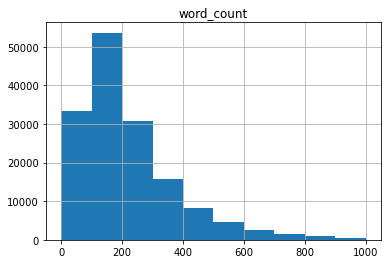

In [18]:
words_count = sample[['word_count']]
words_count = words_count[words_count.word_count < 1000]
words_count.hist()
plt.show()

2.2 Гистограмма количества символов в отзыве

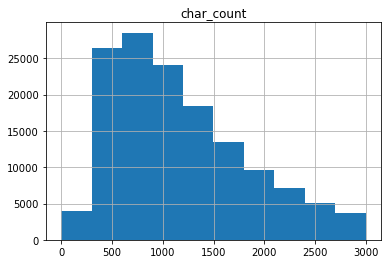

In [19]:
chars_count = sample[['char_count']]
chars_count = chars_count[chars_count.char_count < 3000]
chars_count.hist()
plt.show()

#### 3. Найдите 10 самых частых: слов, без учета стоп-слов, лемм

10 самых популярных слов

In [20]:
words = [word for text in sample.text for word in text.split()]

In [21]:
words = pd.DataFrame(words)
words[0].value_counts().head(10)

в        1330550
и        1058997
не        855335
на        707935
что       640057
я         577500
с         464037
по        372769
мне       320958
банка     275906
Name: 0, dtype: int64

10 самых популярных слов без учета стоп-слов

In [22]:
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']

print(mystopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [23]:
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
sample.text = sample.text.apply(remove_stopwords) 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [24]:
sample.loc[:, 'word_count_no_stop'] = sample.loc[:, 'text'].apply(word_count)
sample.loc[:, 'char_count_no_stop'] = sample.loc[:, 'text'].apply(char_count)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [25]:
words = [word for text in sample.text for word in text.split()]
words_no_stop = pd.DataFrame(words)
words_no_stop[0].value_counts().head(10)

банка        275906
банк         215426
деньги       131201
карту        105829
карты        101821
кредит        81136
день          76552
банке         72169
заявление     70423
очень         66824
Name: 0, dtype: int64

10 самых частых лемм
Поскольку на компьютере под управлением ОС MS Windows лемматизация работает очень медленно (по предварительным оценкам, на лемматизацию первых 10 отзывов затрачивается 12,7 с, т.е., на лемматизацию одного отзыва затрачивается порядка 1,27 с), определим 10 самых частых лемм по первым 100 отзывам.

In [26]:
from pymystem3 import Mystem

In [27]:
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [28]:
sample = df[['text']]

In [29]:
small_sample = sample.head(100)

In [30]:
len(small_sample)

100

In [31]:
small_sample.head()

,text
0,Добрый день! Я не являюсь клиентом банка и пор...
1,Доброго дня! Являюсь держателем зарплатной кар...
2,Здравствуйте! Дублирую свое заявление от 03.0...
3,Добрый день!! Я открыл расчетный счет в СберБа...
4,"04.03.2015 г. взяла кредит в вашем банке, заяв..."


In [32]:
%%time 
small_sample.text = small_sample.text.apply(lemmatize)

Wall time: 1min 54s


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [33]:
small_sample.head()

,text
0,добрый день! я не являться клиент банк и поруч...
1,добрый день! являться держатель зарплатной кар...
2,здравствовать! дублировать свой заявление от ...
3,добрый день!! я открывать расчетный счет в сбе...
4,"04.03.2015 г. взять кредит в ваш банк, заявлят..."


Удаление стоп-лемм

In [85]:
mystoplemmas = stopwords.words('russian') + \
['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', '-']
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() 
                         if not token in mystoplemmas])
    except:
        return ""

In [86]:
small_sample.text = small_sample.text.apply(remove_stoplemmas)

In [87]:
lemmas = [lemma for text in small_sample.text for lemma in text.split()]
lemmas_no_stop = pd.DataFrame(lemmas)
lemmas_no_stop[0].value_counts().head(10)

банк       192
карта      111
кредит      81
весь        74
счет        63
сумма       62
данный      60
который     59
свой        51
мочь        51
Name: 0, dtype: int64

#### 4. Найдите 10 самых частых существительных

In [104]:
#!pip install ufal.udpipe

In [38]:
from ufal.udpipe import Model, Pipeline

In [39]:
model = Model.load("russian-ud-2.0-170801.udpipe") # path to the model

In [40]:
model

<Swig Object of type 'model *' at 0x00000200664EA5B0>

In [41]:
pipeline = Pipeline(model, 'generic_tokenizer', '', '', '')

In [195]:
sample = df[['text']]

In [179]:
sample.text[0]

'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор, мне по меньшей мере не понятно,\xa0 и почему по Вашей милости я должна переживать и бояться за себе и свое имущество. Письма доставляют мн

In [44]:
parsed = pipeline.process(sample.text[0])

In [45]:
type(parsed)

str

In [46]:
parsed

'# newdoc\n# newpar\n# sent_id = 1\n# text = Добрый день!\n1\tДобрый\tДобрый\tADJ\tJJL\tAnimacy=Inan|Case=Nom|Gender=Masc|Number=Sing\t2\tamod\t_\t_\n2\tдень\tДЕНЬ\tNOUN\tNN\tAnimacy=Inan|Case=Nom|Gender=Masc|Number=Sing\t0\troot\t_\tSpaceAfter=No\n3\t!\t!\tPUNCT\t.\t_\t2\tpunct\t_\t_\n\n# sent_id = 2\n# text = Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно оформившим отношения с банком по поводу урегулирования чьей-либо задолженности.\n1\tЯ\tЯ\tPRON\tPRP\tCase=Nom|Number=Sing|Person=1\t3\tnsubj\t_\t_\n2\tне\tНЕ\tPART\tNEG\tPolarity=Neg\t3\tadvmod\t_\t_\n3\tявляюсь\tявляюсь\tVERB\tVBG\tAspect=Imp|VerbForm=Conv\t24\tacl\t_\t_\n4\tклиентом\tклиентом\tNOUN\tNN\tAnimacy=Inan|Case=Ins|Gender=Masc|Number=Sing\t3\tiobj\t_\t_\n5\tбанка\tБАНК\tNOUN\tNN\tAnimacy=Inan|Case=Gen|Gender=Masc|Number=Sing\t4\tnmod\t_\t_\n6\tи\tИ\tCCONJ\tCC\t_\t7\tcc\t_\t_\n7\tпоручителем\tпорУЧИТЕЛЬ\tNOUN\tNN\tAnimacy=Anim|Case=Ins|Gender=Masc|Nu

In [47]:
print(parsed)

# newdoc
# newpar
# sent_id = 1
# text = Добрый день!
1	Добрый	Добрый	ADJ	JJL	Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing	2	amod	_	_
2	день	ДЕНЬ	NOUN	NN	Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing	0	root	_	SpaceAfter=No
3	!	!	PUNCT	.	_	2	punct	_	_

# sent_id = 2
# text = Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно оформившим отношения с банком по поводу урегулирования чьей-либо задолженности.
1	Я	Я	PRON	PRP	Case=Nom|Number=Sing|Person=1	3	nsubj	_	_
2	не	НЕ	PART	NEG	Polarity=Neg	3	advmod	_	_
3	являюсь	являюсь	VERB	VBG	Aspect=Imp|VerbForm=Conv	24	acl	_	_
4	клиентом	клиентом	NOUN	NN	Animacy=Inan|Case=Ins|Gender=Masc|Number=Sing	3	iobj	_	_
5	банка	БАНК	NOUN	NN	Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing	4	nmod	_	_
6	и	И	CCONJ	CC	_	7	cc	_	_
7	поручителем	порУЧИТЕЛЬ	NOUN	NN	Animacy=Anim|Case=Ins|Gender=Masc|Number=Sing	4	conj	_	_
8	по	ПО	ADP	IN	_	10	case	_	_
9	кредитному	кредитному	ADJ	JJL	Animacy=Inan|Case=Dat

In [48]:
regex_0 = re.compile("\n\d+\t[А-Яа-я]+\t[А-Яа-я]+\tNOUN")

In [49]:
regex_1 = re.compile("\t[А-Яа-я]+\tNOUN")

In [50]:
dumb_1 = regex_1.findall(parsed)

In [51]:
regex_2 = re.compile("[А-Яа-я]+")

In [52]:
dumb_2 = regex_2.findall(dumb_1[1])

In [53]:
len(sample)

153499

In [54]:
%%time 
list_1 = []
regex_1 = re.compile("\t[А-Яа-я]+\tNOUN")
regex_2 = re.compile("[А-Яа-я]+")
for i in range(1000):
    parsed = pipeline.process(sample.text[i])
    dumb_1 = regex_1.findall(parsed)
    for j in range(len(dumb_1)):
        dumb_2 = regex_2.findall(dumb_1[j])
        list_1.append(dumb_2[0].lower())     

Wall time: 3min 4s


In [55]:
from collections import Counter

In [56]:
Counter(list_1).most_common(10)

[('банк', 2639),
 ('карта', 1642),
 ('день', 819),
 ('деньги', 817),
 ('год', 671),
 ('сумма', 650),
 ('сотрудник', 572),
 ('кредит', 566),
 ('вклад', 566),
 ('отделение', 552)]

In [57]:
len(list_1)

58404

#### 5. Постройте кривые Ципфа и Хипса

Кривая Ципфа

In [ ]:
list_11 = pd.DataFrame(list_1)

In [70]:
list_11[0].value_counts()

банк             2639
карта            1642
день              819
деньги            817
год               671
                 ... 
означенному         1
стати               1
айманибанк          1
автоответчика       1
приоритете          1
Name: 0, Length: 6752, dtype: int64

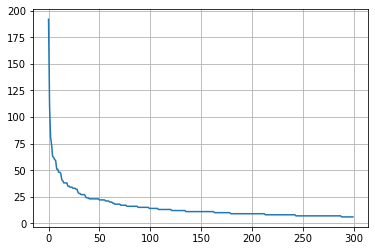

In [88]:
freqs = lemmas_no_stop[0].value_counts()

fig, ax = plt.subplots()
ax.plot(range(300), freqs[:300])
plt.grid()
plt.show()

In [92]:
lemmas_no_stop[0].value_counts().head(300)

банк       192
карта      111
кредит      81
весь        74
счет        63
          ... 
месяц,       6
горячий      6
общий        6
просьба      6
зайти        6
Name: 0, Length: 300, dtype: int64

Кривая Хипса

In [180]:
df = pd.DataFrame(sample.text)

In [182]:
df_10k = df.head(10000)

In [183]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df_10k.iterrows(), total = len(df_10k)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))


100%|██████████| 10000/10000 [01:12<00:00, 137.07it/s]


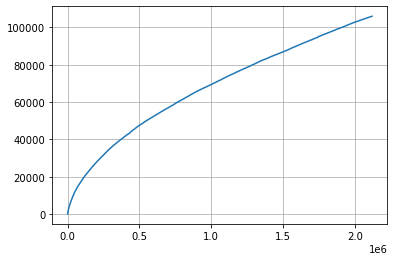

In [184]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.grid()
plt.show()

#### 6. Ответьте на следующие вопросы:
* какое слово встречается чаще, "сотрудник" или "клиент"?
* сколько раз встречается слова "мошенничество" и "доверие"?

In [185]:
freqs['сотрудник']

47

In [187]:
freqs['клиент']

41

Вывод: слово "сотрудник" встречается чаще, чем слово "клиент".

In [188]:
freqs['мошенничество']

1

In [189]:
freqs['доверие']

2

Вывод: слово "доверие" встречается чаще, чем слово "мошенничество".

#### 7. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру  𝑡𝑓−𝑖𝑑𝑓 , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [214]:
data = pd.DataFrame(responses)

In [216]:
data_neg = data[data.rating_grade == 1]

In [218]:
data_neg.shape

(47387, 10)

In [219]:
data_pos = data[data.rating_grade == 5]

In [220]:
data_pos.shape

(14713, 10)

Ключевые слова

In [232]:
vec_neg = TfidfVectorizer()
bow_neg = vec_neg.fit_transform(data_neg.text)

In [241]:
vec_neg.get_feature_names()[0:10]

['00',
 '000',
 '0000',
 '00000',
 '000000',
 '0000000',
 '00000000',
 '0000000000',
 '00000000000',
 '000000000000000']

In [238]:
vec_pos = TfidfVectorizer()
bow_pos = vec_pos.fit_transform(data_pos.text)

In [240]:
vec_pos.get_feature_names()[0:10]

['00',
 '000',
 '0000',
 '00000',
 '000001570510',
 '00001422',
 '0001',
 '000107',
 '0001639',
 '00017']

Биграммы

In [242]:
vec_neg_2 = TfidfVectorizer(ngram_range = (2,2))
bow_neg = vec_neg_2.fit_transform(data_neg.text)

In [243]:
vec_neg_2.get_feature_names()[0:10]

['00 00',
 '00 000',
 '00 0000',
 '00 00eur',
 '00 00ч',
 '00 01',
 '00 017322',
 '00 02',
 '00 03',
 '00 03мар']

In [244]:
vec_pos_2 = TfidfVectorizer(ngram_range = (2,2))
bow_pos = vec_pos_2.fit_transform(data_pos.text)

In [247]:
vec_pos_2.get_feature_names()[1000 : 1010]

['01 2010',
 '01 2011',
 '01 2012',
 '01 2012г',
 '01 2013',
 '01 2014',
 '01 2014г',
 '01 2015',
 '01 2015г',
 '01 22']

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [331]:
texts = [text.split() for text in data.text]

In [333]:
len(texts)

153499

In [332]:
dictionary = Dictionary(texts)

In [334]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [335]:
len(corpus)

153499

In [336]:
len(dictionary)

1111876

In [338]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [340]:
# Тематическая модель для числа тем, равного 30
lsi = lsimodel.LsiModel(corpus = corpus_tfidf, id2word = dictionary, num_topics = 30)

In [344]:
# Пример интерпретируемой темы про QIWI-кошелек
lsi.show_topic(20)

[('кошелек', 0.19866145419532893),
 ('средств', -0.19370977998987404),
 ('средства', -0.18932384476829386),
 ('смс', -0.18711900500531248),
 ('денежных', -0.18534055742331812),
 ('денежные', -0.17850429709974458),
 ('киви', 0.16944104040594696),
 ('QIWI', 0.15050872722886122),
 ('-', -0.11758635674300033),
 ('службу', 0.1147689423298877)]

2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

In [347]:
lsi.show_topic(23)

[('звонки', 0.2444089869277422),
 ('кошелек', 0.22243242509375957),
 ('QIWI', 0.19518534722413602),
 ('киви', 0.17497470963107573),
 ('смс', -0.1655175416307376),
 ('средства', 0.14634943881949525),
 ('денежные', 0.12939792939774022),
 ('денежных', 0.12367113948663433),
 ('Visa', 0.12045881373990765),
 ('Сбербанка', -0.11407363824842677)]

Можно предположить, что в этой теме речь идет о переводе денежных средств с карты Сбербанка на QIWI-кошелек.

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

#### 1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5

In [264]:
data_neg.loc[ : ,'type'] = 'neg'

In [302]:
data_neg_1 = data_neg.sample(data_pos.shape[0])

In [304]:
data_neg_1.shape

(14713, 11)

In [261]:
data_pos.loc[ : ,'type'] = 'pos'

In [292]:
data_pos.shape[0]

14713

In [305]:
data_all = data_neg_1.merge(data_pos, how = 'outer')

In [306]:
data_all.tail()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,type
29421,None,False,Повысилось качество обслуживания,0,лицензия № 1623,Атмос,ВТБ 24,2005-04-13 12:00:00,Пользуюсь банком 3 месяца - специально открыл ...,5.0,pos
29422,None,False,Стабильный банк с высокими процентами,0,лицензия № 1971,Александра,Ханты-Мансийский банк Открытие,2005-04-14 13:41:00,А что писать? Ставки по вкладам высокие (до 13...,5.0,pos
29423,None,False,Ну тогда копите денюжки и покупайте не в креди...,4,лицензия № 2289,irzik,Русский Стандарт,2005-04-14 17:42:00,А я с мужем обставила техникой совершенно нову...,5.0,pos
29424,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0,pos
29425,None,False,Быстро и удобно,0,лицензия № 1326,Денис,Альфа-Банк,2005-04-13 17:43:00,"Если коротко, то мне нравится. Кридит получать...",5.0,pos


In [307]:
x_train, x_test, y_train, y_test = train_test_split(data_all.text, data_all.type)

#### 2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных  𝑛 -грам

**CountVectorizer**  
**Униграмма**

In [308]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)

In [309]:
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [310]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         neg       0.95      0.95      0.95      3659
         pos       0.95      0.95      0.95      3698

    accuracy                           0.95      7357
   macro avg       0.95      0.95      0.95      7357
weighted avg       0.95      0.95      0.95      7357



**Биграмма**

In [311]:
vec = CountVectorizer(ngram_range=(2, 2))
bow = vec.fit_transform(x_train)

In [312]:
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [313]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         neg       0.94      0.94      0.94      3657
         pos       0.94      0.94      0.94      3700

    accuracy                           0.94      7357
   macro avg       0.94      0.94      0.94      7357
weighted avg       0.94      0.94      0.94      7357



При использовании биграмм результат ухудшился приблизительно на 0,01.

**Триграмма**

In [314]:
vec = CountVectorizer(ngram_range=(2, 2))
bow = vec.fit_transform(x_train)

In [315]:
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [316]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         neg       0.94      0.94      0.94      3657
         pos       0.94      0.94      0.94      3700

    accuracy                           0.94      7357
   macro avg       0.94      0.94      0.94      7357
weighted avg       0.94      0.94      0.94      7357



При использовании триграмм результат не изменился.
Таким образом, получены следующие значения precision и f1-score:
    * униграмма: 0,95;
    * биграмма:  0,94;
    * триграмма: 0,94.

**TfidfVectorizer**  
**Униграмма**

In [317]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)

In [318]:
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [319]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         neg       0.96      0.95      0.95      3711
         pos       0.95      0.96      0.95      3646

    accuracy                           0.95      7357
   macro avg       0.95      0.95      0.95      7357
weighted avg       0.95      0.95      0.95      7357



При использовании TF-IDF для униграмм значение точности при предсказании отрицательных отзывов незначительно увеличилось (до 0,96).

**Биграмма**

In [320]:
vec = TfidfVectorizer(ngram_range=(2, 2))
bow = vec.fit_transform(x_train)

In [321]:
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [322]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         neg       0.95      0.92      0.93      3759
         pos       0.92      0.95      0.93      3598

    accuracy                           0.93      7357
   macro avg       0.93      0.93      0.93      7357
weighted avg       0.93      0.93      0.93      7357



In [ ]:
Использование TF-IDF для биграмм приводит к снижени точности предсказания положительных отзывов до 0,92.

**Триграммы**

In [323]:
vec = TfidfVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)

In [324]:
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [325]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         neg       0.91      0.87      0.89      3825
         pos       0.87      0.91      0.89      3532

    accuracy                           0.89      7357
   macro avg       0.89      0.89      0.89      7357
weighted avg       0.89      0.89      0.89      7357



Использование TF-IDF для триграмм ведет к дальнейшему снижению точности предсказания.
Таким образом, получены следующие значения f1-score:
* униграммы: 0,95;
* биграммы:  0,93;
* триграммы: 0,89.

3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:

In [400]:
clf_svd = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tm', TruncatedSVD(n_components = 1000)), 
    ('clf', LogisticRegression(random_state=42, solver='liblinear')),
])
clf_svd.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()),
                ('tm', TruncatedSVD(n_components=1000)),
                ('clf',
                 LogisticRegression(random_state=42, solver='liblinear'))])

In [401]:
pred = clf_svd.predict(x_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         neg       0.94      0.94      0.94      3644
         pos       0.94      0.94      0.94      3713

    accuracy                           0.94      7357
   macro avg       0.94      0.94      0.94      7357
weighted avg       0.94      0.94      0.94      7357



При количестве компонент, равном 1000, удается достичь значения f1-score, равного 0,94, что несколько ниже аналогичного значения для простого CountVectorizer для униграмм (0,95).

In [407]:
clf_lda = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tm', LDA(n_components=60, max_iter = 4,
              n_jobs=4, learning_method='batch',
              verbose=1)), 
    ('clf', LogisticRegression(random_state=42, solver='liblinear')),
])
clf_lda.fit(x_train, y_train)

iteration: 1 of max_iter: 4
iteration: 2 of max_iter: 4
iteration: 3 of max_iter: 4
iteration: 4 of max_iter: 4


Pipeline(steps=[('vect', CountVectorizer()),
                ('tm',
                 LatentDirichletAllocation(max_iter=4, n_components=60,
                                           n_jobs=4, verbose=1)),
                ('clf',
                 LogisticRegression(random_state=42, solver='liblinear'))])

In [408]:
pred = clf_lda.predict(x_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         neg       0.91      0.85      0.88      3900
         pos       0.85      0.91      0.88      3457

    accuracy                           0.88      7357
   macro avg       0.88      0.88      0.88      7357
weighted avg       0.88      0.88      0.88      7357



При количестве компонент, равном 60, удается достичь значения f1-score, равного 0,88, что несколько ниже аналогичного значения для простого CountVectorizer для униграмм (0,95).